# Multiple basins
This example demonstrates the power of the `rapbro` interface to Google Earth Engine (GEE) to collect many subbasin attributes associated with multiple coordinate pairs. 

In [13]:
import os
import pandas as pd
import geopandas as gpd
import contextily as cx # You may need to 'conda install contextily' or 'pip install contextily'
import matplotlib.pyplot as plt

import rabpro
from rabpro.basin_stats import Dataset

os.environ['RABPRO_DATA'] = r'X:\Data' # Point this to your rabpro datapath if it different than the default

If you have not authenticated Google Earth Engine yet, this is a good time to do it. Running the following code should prompt you for an authorization token and instructions for getting it.

In [ ]:
import ee
ee.Authenticate()

First let's create a list of coordinate pairs that we'll use to delineate our basins of interest. For this example, we'll retrieve the subbasins associated with dams in Sri Lanka. Data are from [VotE-Dams](https://data.ess-dive.lbl.gov/view/doi:10.15485/1843541).

In [2]:
dam_coords = [(9.299352, 80.324096), (6.9159649, 81.0100197), (8.1709424, 80.223766), (8.3519444, 80.3852778), (6.8577186, 80.5855038), (6.3098805, 80.8557684), (7.3017445, 80.700303), (7.8666667, 80.6166667), (5.9907437, 80.654368), (7.29212186, 80.63798077), (6.1064653, 80.6434438), (7.8002358, 80.5507896), (7.1644604, 81.6172083), (6.0966667, 80.5980556), (7.9926439, 80.9124781), (7.7713804, 80.4618547), (6.6663889, 81.1519444), (8.2166667, 80.7166667), (7.21031, 81.534525), (9.342165, 80.447647), (6.8531681, 80.1937833), (8.0116232, 80.5577336), (7.8749822, 80.7075809), (8.166120326, 80.92907567), (5.97662322, 80.59436068), (7.060356, 80.598767), (6.58, 80.326944), (6.8356819, 80.1798343), (8.5977778, 80.9497222), (8.3951818, 80.5521785), (8.4649153, 80.1930859), (7.276247, 81.0395821), (6.4406287, 80.9580932), (8.027173, 80.89291), (8.5850794, 81.0064442), (6.9811916, 81.5020328), (8.251949, 80.469926), (7.2667672, 81.1002985), (7.6801531, 80.6139585), (7.296071, 81.5130095), (7.4583255, 81.6007655), (6.913889, 80.521667), (8.347577, 80.419759), (8.8077739, 80.7574688), (7.9448769, 80.292059), (7.0793219, 81.6281681), (7.895393, 80.988042), (8.6907253, 80.4298704), (7.7185503, 81.1885293), (7.3219103, 80.645308), (6.9190503, 80.4894399), (8.1325, 80.2458333), (7.201942, 80.922261), (7.1996059, 80.9496288), (7.5082139, 81.0558007), (6.2057327, 80.9843446), (7.6461111, 81.4808333), (6.675005, 80.7865558), (8.0727324, 79.9556424), (6.428509, 80.838542), (7.618288, 81.5488207), (6.946745731, 80.65814325), (8.0608333, 80.3175), (9.090326112, 80.33821621), (7.241352, 80.783926), (8.7224936, 80.8350109), (6.5474919, 81.260143), (7.647458, 81.213197)]
dam_ids = [13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 22927]
dam_das = [116.0, 1.6, 131.0, 4.0, 138.0, 176.0, 0.95, 155.0, 4.15, 2.75, 7.03, 26.0, 32.0, 4.9, 1.08, 58.0, 45.0, 0.79, 992.0, 555.0, 16.16, 834.0, 96.9, 88.0, 5.5, 572.0, 318.0, 5.7, 152.0, 326.0, 405.0, 2.79, 231.0, 213.0, 73.7, 69.2, 598.0, 72.6, 29.7, 30.9, 181.0, 173.6, 834.5, 552.0, 19.2, 26.3, 85.7, 297.25, 102.2, 1350.0, 170.7, 1616.0, 2350.0, 3109.0, 38.7, 26.8, 981.0, 340.0, 311.0, 1160.0, 239.0, 312.0, 183.0, 250.0, 1900.0, 72.0, 549.8, 470.5]
vdams_srilanka = pd.DataFrame(data={'coords':dam_coords, 'vote_id':dam_ids, 'da_km2':dam_das})
vdams_srilanka.head()

,coords,vote_id,da_km2
0,"(9.299352, 80.324096)",13331,116.0
1,"(6.9159649, 81.0100197)",13332,1.6
2,"(8.1709424, 80.223766)",13333,131.0
3,"(8.3519444, 80.3852778)",13334,4.0
4,"(6.8577186, 80.5855038)",13335,138.0


We loop through each coordinate pair and delineate its watershed using MERIT (this is only possible if an estimated drainage area is known, which is the case here, else `rabpro` would use HydroBasins), then combine all watershed polygons into a GeoDataFrame. If you want to use MERIT, download tile 'n00e060' following the MERIT download [example](https://github.com/VeinsOfTheEarth/rabpro/blob/main/docs/source/examples/notebooks/downloading_data.ipynb).

In [18]:
if os.path.isfile("basins_sl.gpkg") is False:
    basins_sl = []
    for i, row in vdams_srilanka.iterrows():
        print(i)
        rpo = rabpro.profiler(row['coords'], da=row['da_km2'], verbose=False)
        rpo.delineate_basin(force_merit=True)
        rpo.watershed['vote_id'] = row['vote_id']
        basins_sl.append(rpo.watershed)
        
    basins_sl = pd.concat(basins_sl)
    basins_sl.to_file("basins_sl.gpkg", driver="GPKG")
else:
    basins_sl = gpd.read_file("basins_sl.gpkg")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


We need to upload our basin vector layer as a GEE asset because it too large to send as a json payload. This can be done manually through the GEE code editor or via `rabpro` automation. This automation requires that you have a writeable Google Cloud Platform (GCP) bucket and that you are authenticated via the command-line to call the `gsutil` and `earthengine` programs. These programs enable sending files to GCP and onward to GEE respectively.

For now, you can skip this step as we've uploaded the sl_basins file as a public asset.

```python
gcp_bucket = "your_gcp_bucket"
gee_user = "your_gee_username"
zip_path = rabpro.utils.build_gee_vector_asset(basins_sl, "basins_sl.zip")
your_gee_asset = rabpro.utils.upload_gee_vector_asset(
    zip_path, gee_user, gcp_bucket, gcp_folder="rabpro"
)

```

We'd like to get zonal statistics over each of our delineated basins. We need to first define a list of Google Earth Engine (GEE) datasets we'd like to sample. 

In [19]:
dataset_list = [
    Dataset(
        "JRC/GSW1_3/GlobalSurfaceWater",
        "occurrence",
        time_stats=["median"],
        stats=["mean"],
    ),
    Dataset(
        "ECMWF/ERA5_LAND/MONTHLY",
        "temperature_2m",
        time_stats=["median"],
        stats=["mean"],
    ),
    Dataset(
        "UCSB-CHG/CHIRPS/DAILY", "precipitation", time_stats=["median"], stats=["mean"]
    ),
]

Now let's do the sampling with `rabpro.basin_stats.compute()`, format the results, and join it to our basins GeoDataFrame.

In [22]:
your_gee_asset = 'users/jonschwenk/sl_basins'

In [23]:
# This could take minutes to run, depending on how quickly GEE completes your tasks.
if not os.path.exists("res.gpkg"):
    urls, tasks = rabpro.basin_stats.compute(
        dataset_list, gee_feature_path=your_gee_asset, folder="rabpro"
    )
    tag_list = ["wateroccur", "temperature_2m", "precip"]
    data = rabpro.basin_stats.format_gee(urls, tag_list)
    data['vote_id'] = data['precip_vote_id'].values
    data = data.drop([k for k in data.keys() if '_vote_id' in k], axis=1)

    res = gpd.GeoDataFrame(basins_sl.merge(data, on='vote_id'))
    res = res.set_geometry("geometry")
    res.to_file("res.gpkg", driver="GPKG")
else:
    res = gpd.read_file("res.gpkg")

Finally, we can visualize our results!

TypeError: __init__() got an unexpected keyword argument 'label'

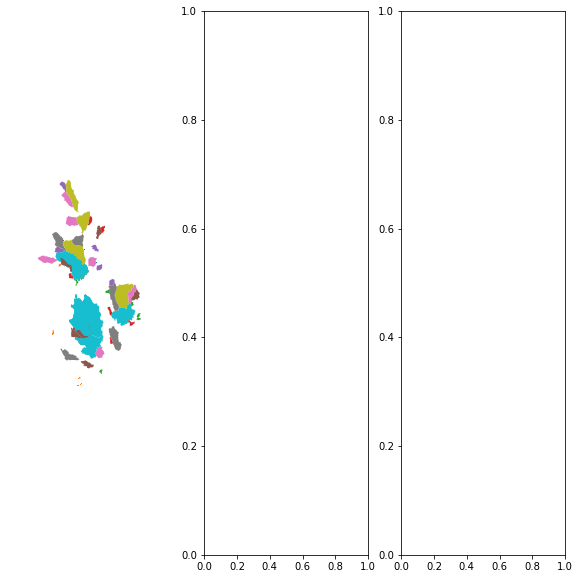

In [24]:
def build_panel(col_name, col_label, axis):
    axis.set_xlim([left-0.5, right+0.5])
    axis.set_ylim([bot-0.2, top+0.2])
    axis.set_axis_off()
    res.plot(
        ax=axis,
        column=col_name,
        legend=True,
        legend_kwds={"label": col_label, "orientation": "horizontal", "pad": 0.01},
    )    
    cx.add_basemap(axis, zoom=10, crs=res.crs, attribution="")
    return axis


left, bot, right, top = res.total_bounds
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax = [
    build_panel(col_name, col_label, ax[i])
    for col_name, col_label, i in zip(
        [x for x in res.columns[0:3]],
        ["Water occurence %", "Temperature (K)", "Precipitation (mm/day)"],
        range(0, 3),
    )
]